# **项目：短期电力负荷预测系统**

## 一. 配备环境与数据准备

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product
import warnings
import time
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# 设置可视化风格
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 12

## 二. 数据加载与预处理

### 1.加载原始数据

In [3]:
original_data = pd.read_csv('data/raw_load_data.csv', parse_dates=['Datetime'])
cleaned_data = original_data.copy()

### 2.处理原始数据

In [4]:
cleaned_data.rename(columns={'PJME_MW': 'Load'}, inplace=True)
cleaned_data = cleaned_data.sort_values('Datetime').reset_index(drop=True)
cleaned_data['Datetime'] = pd.to_datetime(cleaned_data['Datetime'])
cleaned_data.set_index('Datetime', inplace=True)

In [5]:
missing_count = cleaned_data['Load'].isnull().sum()
if missing_count > 0:
    print(f"  • 检测到 {missing_count} 个缺失值，使用线性插值填充")
    df['Load'] = df['Load'].interpolate(method='linear')

In [6]:
print(f"  • 数据范围: {cleaned_data.index[0]} 至 {cleaned_data.index[-1]}")
print(f"  • 总记录数: {len(cleaned_data)} 小时数据")
print(f"  • 平均负荷: {cleaned_data['Load'].mean():.0f} MW")
print(f"  • 负荷峰值: {cleaned_data['Load'].max():.0f} MW")
print(f"  • 负荷谷值: {cleaned_data['Load'].min():.0f} MW")

  • 数据范围: 2002-01-01 01:00:00 至 2018-08-03 00:00:00
  • 总记录数: 145366 小时数据
  • 平均负荷: 32080 MW
  • 负荷峰值: 62009 MW
  • 负荷谷值: 14544 MW


## 三. 探索与分析数据

### 1. 创建时间特征

In [7]:
features = pd.DataFrame(index=cleaned_data.index)
features['hour'] = cleaned_data.index.hour
features['dayofweek'] = cleaned_data.index.dayofweek
features['month'] = cleaned_data.index.month
features['weekofyear'] = cleaned_data.index.isocalendar().week

### 2.分析一日的周期性

  • 日负荷峰值: 约 19:00 (36427 MW)


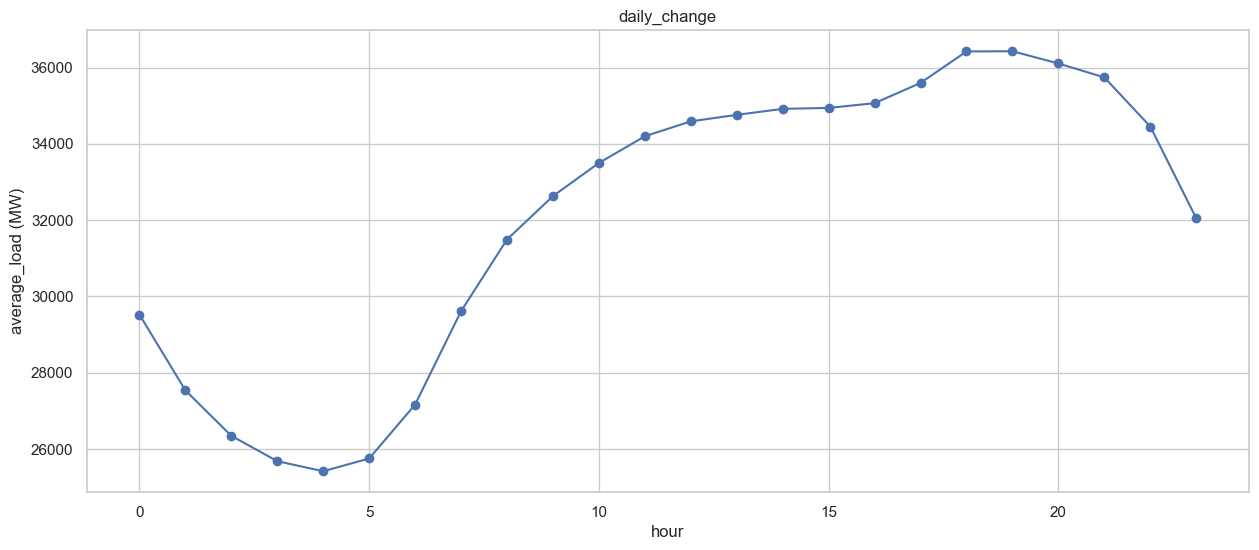

In [8]:

hourly = cleaned_data.groupby(features['hour']).mean()
plt.plot(hourly.index, hourly.values, 'bo-')
plt.title('daily_change')
plt.xlabel('hour')
plt.ylabel('average_load (MW)')
plt.grid(True)

peak_hour = hourly['Load'].idxmax()
peak_load = hourly['Load'].max()
print(f"  • 日负荷峰值: 约 {peak_hour}:00 ({peak_load:.0f} MW)")

### 2.分析一周的周期期性

  • 周负荷峰值: TUE (33272 MW)


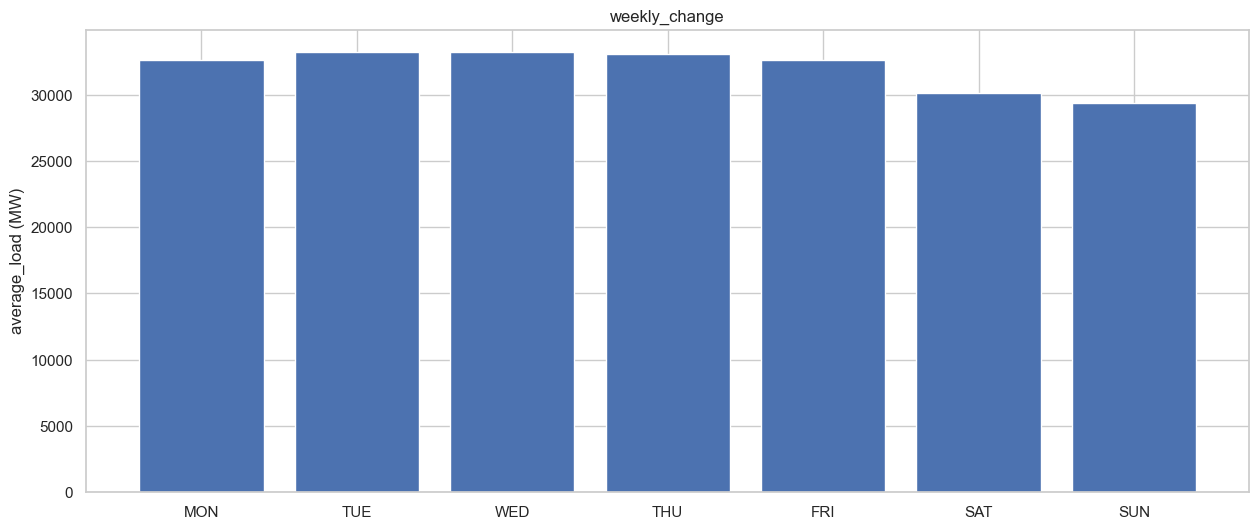

In [9]:
weekday = cleaned_data.groupby(features['dayofweek']).mean()
days = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
plt.bar(range(7), weekday['Load'].values)
plt.xticks(range(7), days)
plt.title('weekly_change')
plt.ylabel('average_load (MW)')
plt.grid(True, axis='y')

weekday_peak = weekday['Load'].idxmax()
weekday_load = weekday['Load'].max()
weekday_name = days[weekday_peak]
print(f"  • 周负荷峰值: {weekday_name} ({weekday_load:.0f} MW)")

### 3.月负荷趋势

  • 月负荷峰值: 7月 (37882 MW)


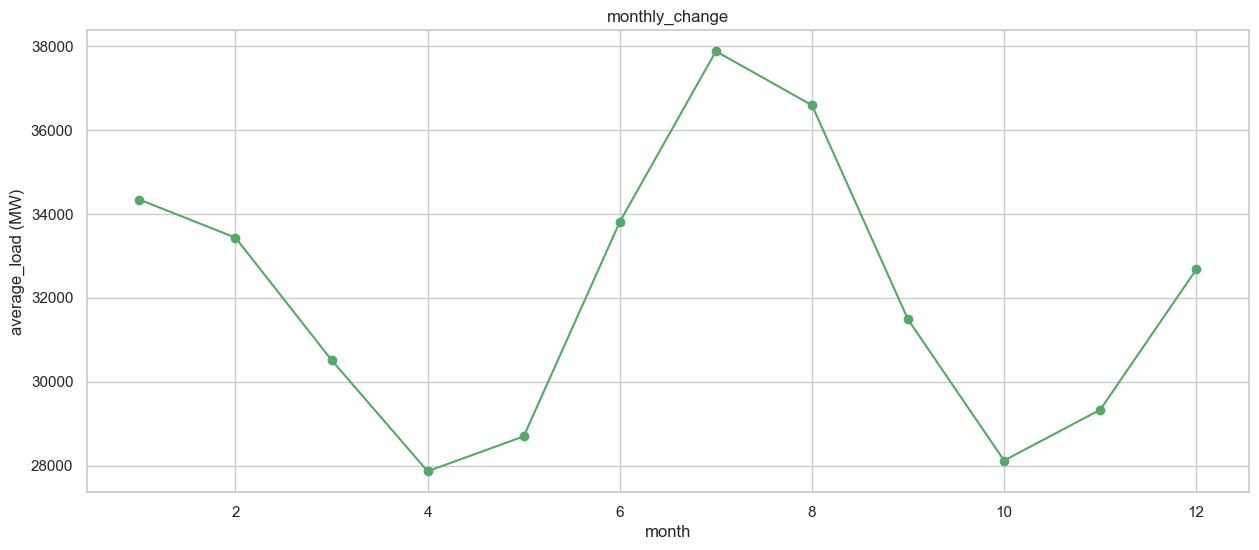

In [10]:
monthly = cleaned_data.groupby(features['month']).mean()
plt.plot(monthly.index, monthly['Load'].values, 'go-')
plt.title('monthly_change')
plt.xlabel('month')
plt.ylabel('average_load (MW)')
plt.grid(True)

highest_month = monthly['Load'].idxmax()
highest_month_load = monthly['Load'].max()
print(f"  • 月负荷峰值: {highest_month}月 ({highest_month_load:.0f} MW)")

### 4.季节分解

  • 季节性强度: 中等 (12.11%)


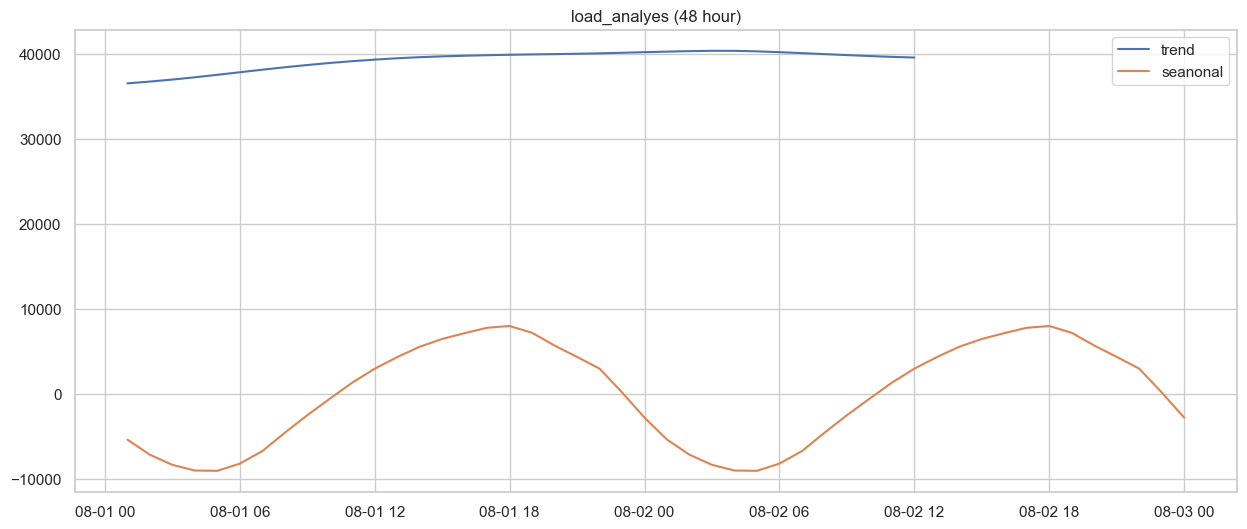

In [11]:
monthly_data = cleaned_data[-(30*24):]  # 取一个月的数据进行分解
result = seasonal_decompose(monthly_data, model='additive', period=24)
plt.plot(result.trend[-48:], label='trend')
plt.plot(result.seasonal[-48:], label='seanonal')
plt.title('load_analyes (48 hour)')
plt.legend()
plt.grid(True)

seasonality_strength = hourly['Load'].std() / hourly['Load'].mean()
is_strong = "强" if seasonality_strength > 0.15 else "中等"
print(f"  • 季节性强度: {is_strong} ({seasonality_strength:.2%})")

## 四 .数据准备与分割

In [12]:
test_days=1
test_size = test_days * 24  # 天数转小时数
train_data = cleaned_data.iloc[:-test_size]
test_data = cleaned_data.iloc[-test_size:]
print(f"  • 训练集: {len(train_data)} 小时 ({train_data.index[0]} 至 {train_data.index[-1]})")
print(f"  • 验证集: {len(test_data)} 小时 ({test_data.index[0]} 至 {test_data.index[-1]})")

  • 训练集: 145342 小时 (2002-01-01 01:00:00 至 2018-08-02 00:00:00)
  • 验证集: 24 小时 (2018-08-02 01:00:00 至 2018-08-03 00:00:00)


## 五. 基于ACF分析选择SARIMA季节参数

### 1.绘制过去48小时数据，直观查看周期性

  • 24小时滞后相关系数: 0.83


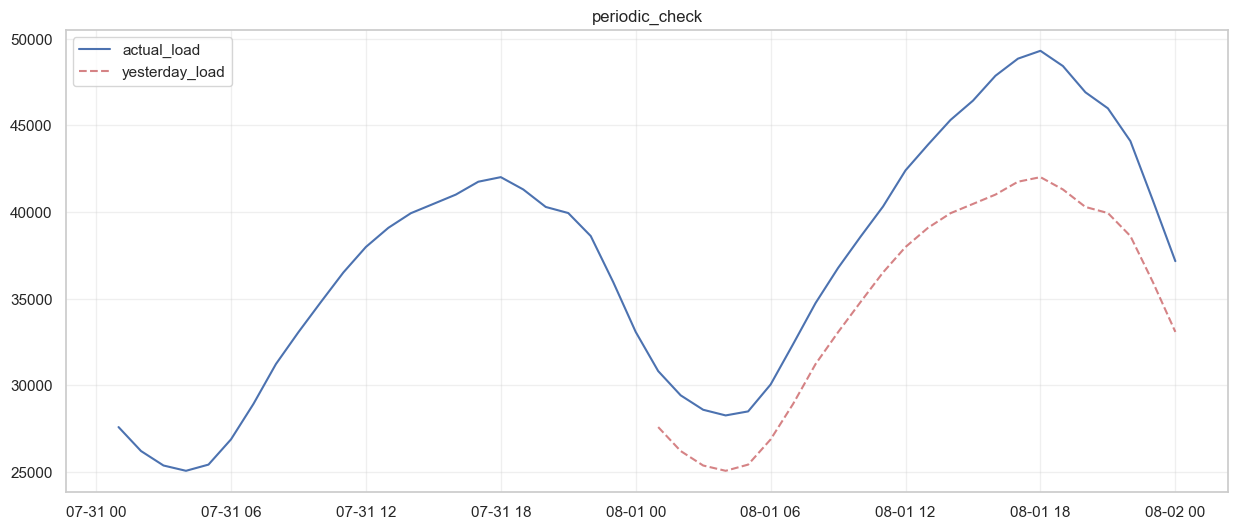

In [13]:
train_selection = cleaned_data.iloc[-168:-24]  # 7天训练，保留24小时验证

plt.plot(train_selection[-48:], 'b-', label='actual_load')
plt.plot(train_selection[-48:].shift(24), 'r--', alpha=0.7, label='yesterday_load')
plt.title('periodic_check')
plt.legend()
plt.grid(True, alpha=0.3)

corr_24h = train_selection['Load'].autocorr(lag=24)
print(f"  • 24小时滞后相关系数: {corr_24h:.2f}")

### 2.计算ACF分析

  • 生成ACF分析图表: acf_analysis.png


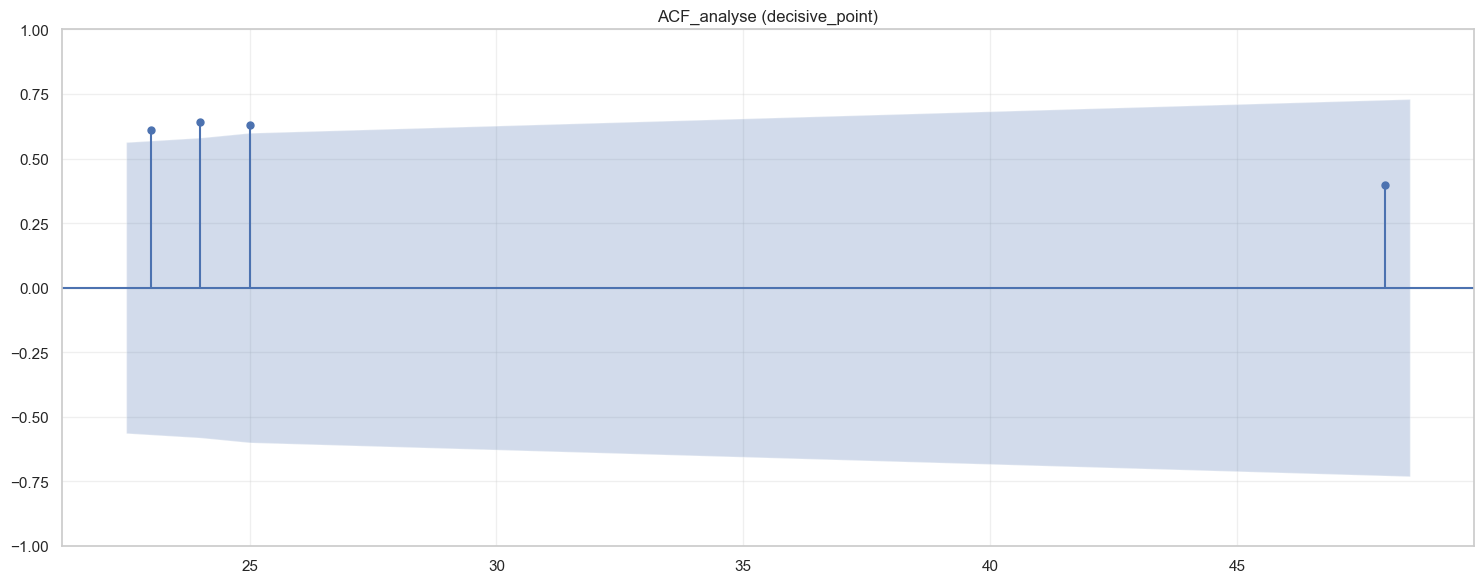

In [14]:
plot_acf(train_selection, lags=[23, 24, 25, 48], alpha=0.05)
plt.title('ACF_analyse (decisive_point)')
plt.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.savefig('acf_analysis.png', dpi=100)
print("  • 生成ACF分析图表: acf_analysis.png")

### 3.平稳性检测

In [15]:
result = adfuller(cleaned_data['Load'].dropna())
print('ADF统计量:', result[0])
print('p值:', result[1])
print('临界值:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')
    
if result[1] > 0.05:
    print("\n结论: 序列不是平稳的")
else:
    print("\n结论: 序列是平稳的,D = 0")

ADF统计量: -19.88134841399182
p值: 0.0
临界值:
	1%: -3.430
	5%: -2.862
	10%: -2.567

结论: 序列是平稳的,D = 0


### 4.根据分析结果选择参数

In [16]:
if corr_24h > 0.4:
        P = 1  # 季节性AR项: 捕获日周期趋势
        Q = 1  # 季节性MA项: 吸收日间随机波动
        D = 0  # 由于序列平稳
        # 根据电力负荷特性确定P、Q值
        print(f"\n✅ 确定季节性参数: P={P}，D=0, Q={Q}")
        print("  • 选择依据: 24小时相关系数>0.4，表明存在强日周期性")
        print("  • SARIMA(0,0,0)x(1,0,1,24)能同时捕获日周期趋势和过滤随机波动")


✅ 确定季节性参数: P=1，D=0, Q=1
  • 选择依据: 24小时相关系数>0.4，表明存在强日周期性
  • SARIMA(0,0,0)x(1,0,1,24)能同时捕获日周期趋势和过滤随机波动


In [17]:
seasonal_params = (1,0,1,24)
print(f"\n 最终SARIMA模型: SARIMA(0,0,0)x(1,0,1,24)")


 最终SARIMA模型: SARIMA(0,0,0)x(1,0,1,24)


## 六 .训练与验证模型

### 1.定义7天训练窗口

In [18]:
window_days = 7
window_size = window_days * 24
recent_train = train_data.iloc[-window_size:]
    
print(f"  • 使用最近 {window_days} 天 ({window_size} 小时) 数据训练模型")

  • 使用最近 7 天 (168 小时) 数据训练模型


### 2.创建 SARIMA 模型

In [19]:
start_train = time.time()
model = SARIMAX(
    recent_train,
    order=(0, 0, 0),
    seasonal_order=(1, 0, 1, 24),  
    simple_differencing=True,
    initialization='approximate_diffuse',
    enforce_stationarity=False
)

C:\Users\陈雨豪\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\陈雨豪\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


### 3.训练模型

In [20]:
trained_model = model.fit(
        disp=False,
        maxiter=200,
        method='bfgs',
        cov_type='none'
    )
train_time = time.time() - start_train

In [21]:
print(f"\n 模型训练完成 | 用时: {train_time:.2f}秒")
print(f"  • 模型 AIC: {trained_model.aic:.2f}")


 模型训练完成 | 用时: 2.12秒
  • 模型 AIC: 4624.09


### 4.在验证集上进行预测

In [22]:
validation_forecast = trained_model.get_forecast(steps=len(test_data))
predicted = validation_forecast.predicted_mean

### 5.计算评估指标

In [23]:
mae = mean_absolute_error(test_data, predicted)
rmse = np.sqrt(mean_squared_error(test_data, predicted))
mape = np.mean(np.abs((test_data['Load'] - predicted) / test_data['Load'])) * 100

### 6.分析高峰时段表现 (7am-10pm)

In [24]:
peak_mask = test_data.index.hour.isin(range(7, 22))
peak_mae = mean_absolute_error(test_data[peak_mask], predicted[peak_mask])

In [25]:
print("\n 模型验证结果:")
print(f"  • 总体 MAE: {mae:.1f} MW")
print(f"  • 总体 RMSE: {rmse:.1f} MW")
print(f"  • MAPE: {mape:.2f}%")
print(f"  • 高峰时段 MAE (7am-10pm): {peak_mae:.1f} MW")


 模型验证结果:
  • 总体 MAE: 1792.8 MW
  • 总体 RMSE: 1952.9 MW
  • MAPE: 4.62%
  • 高峰时段 MAE (7am-10pm): 1635.6 MW


In [26]:
if mae < 2000:
    print("  • 评估: 极佳 - 达到行业领先水平 (MAE < 2000 MW)")
elif mae < 5000:
    print("  • 评估: 良好 - 满足电力调度要求 (MAE < 5000 MW)")
else:
    print("  • 评估: 一般 - 建议优化模型或添加特征")

  • 评估: 极佳 - 达到行业领先水平 (MAE < 2000 MW)


In [27]:
model = trained_model
predicted_values = predicted
mae = mae
rmse = rmse

## 七. 未来负荷预测

### 1.生成预测并计时

In [28]:
forecast_hours=24
start_forecast = time.time()
forecast = model.get_forecast(steps=forecast_hours)
forecast_time = time.time() - start_forecast

### 2.获取预测值

In [36]:
future_load = forecast.predicted_mean
print(f" 预测完成 | 用时: {forecast_time:.3f}秒")
print("\n 预测结果:")
for i, (timestamp, value) in enumerate(zip(future_load.index, future_load.values)):
    print(f"  • {timestamp.strftime('%Y-%m-%d %H:%M')}: {value:.1f} MW")
    if i >= 23:  # 只打印前24条
        break

⏱️ 预测完成 | 用时: 0.007秒

📊 预测结果:
  • 2018-08-02 01:00: 30852.7 MW
  • 2018-08-02 02:00: 29447.7 MW
  • 2018-08-02 03:00: 28612.2 MW
  • 2018-08-02 04:00: 28284.5 MW
  • 2018-08-02 05:00: 28519.0 MW
  • 2018-08-02 06:00: 30076.1 MW
  • 2018-08-02 07:00: 32408.7 MW
  • 2018-08-02 08:00: 34790.7 MW
  • 2018-08-02 09:00: 36817.9 MW
  • 2018-08-02 10:00: 38629.3 MW
  • 2018-08-02 11:00: 40377.7 MW
  • 2018-08-02 12:00: 42461.5 MW
  • 2018-08-02 13:00: 43944.2 MW
  • 2018-08-02 14:00: 45365.6 MW
  • 2018-08-02 15:00: 46477.1 MW
  • 2018-08-02 16:00: 47904.9 MW
  • 2018-08-02 17:00: 48892.0 MW
  • 2018-08-02 18:00: 49343.5 MW
  • 2018-08-02 19:00: 48463.4 MW
  • 2018-08-02 20:00: 46950.5 MW
  • 2018-08-02 21:00: 46029.4 MW
  • 2018-08-02 22:00: 44141.3 MW
  • 2018-08-02 23:00: 40714.6 MW
  • 2018-08-03 00:00: 37205.7 MW


### 3.计算峰值

In [31]:
peak_idx = np.argmax(future_load)
peak_time = future_load.index[peak_idx].strftime('%H:%M')
peak_load = future_load.iloc[peak_idx]

print(f"\n 预测关键节点:")
print(f"  • 预计峰值: {peak_load:.1f} MW ({peak_time})")
print(f"  • 预计谷值: {future_load.min():.1f} MW ({future_load.index[np.argmin(future_load)].strftime('%H:%M')})")


🔑 预测关键节点:
  • 预计峰值: 49343.5 MW (18:00)
  • 预计谷值: 28284.5 MW (04:00)


### 4.构造 DataFrame 输出

In [32]:
forecast_df = pd.DataFrame({
        'datetime': future_load.index,
        'forecast_load': future_load.values
    })

In [33]:
forecast_result = forecast
forecast_df.head()

,datetime,forecast_load
0,2018-08-02 01:00:00,30852.657843
1,2018-08-02 02:00:00,29447.743002
2,2018-08-02 03:00:00,28612.190831
3,2018-08-02 04:00:00,28284.503070
4,2018-08-02 05:00:00,28519.036934


## 八. 可视化预测结果

### 1.图表绘制

  • 生成可视化报告: load_forecast_result.png


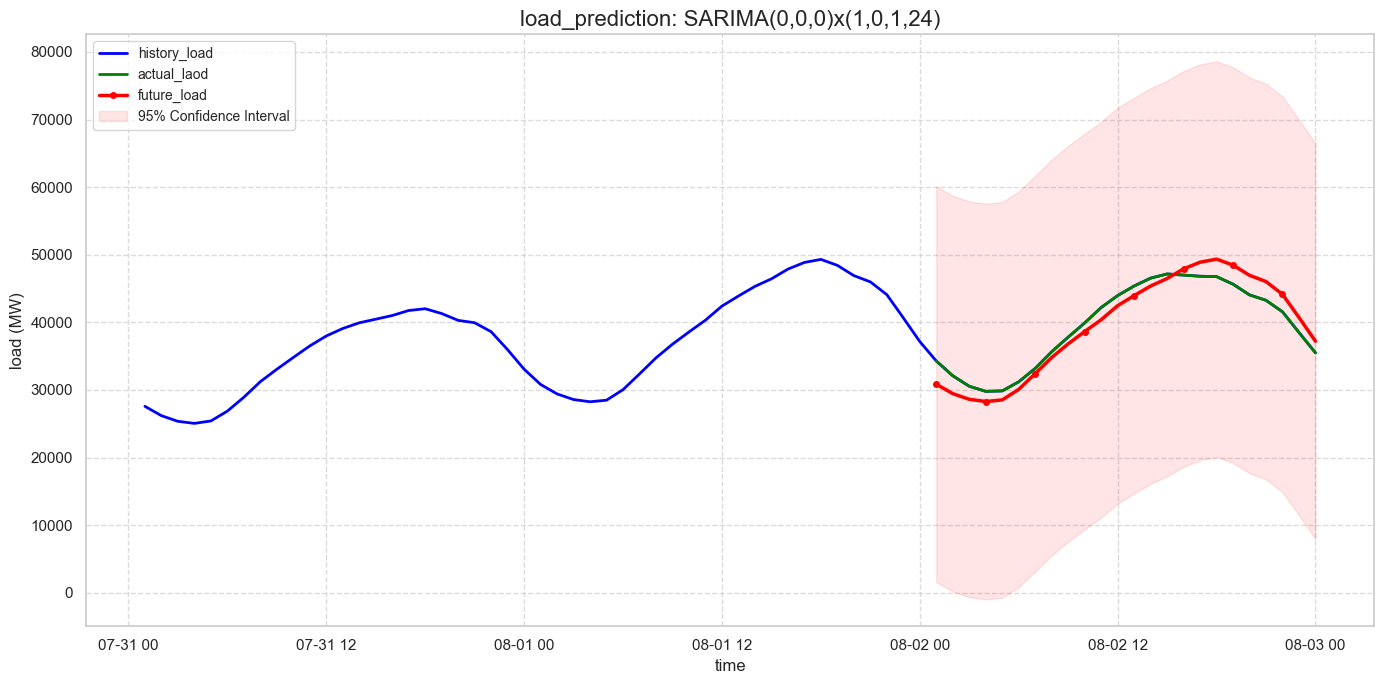

In [34]:
plt.figure(figsize=(14, 7))
plt.plot(cleaned_data.iloc[-72:], label='history_load', color='blue', linewidth=2)
plt.plot(test_data.index, test_data.values, label='actual_laod', color='green', linewidth=2)
forecast_series = pd.Series(forecast_df['forecast_load'].values, index=forecast_df['datetime'])
plt.plot(forecast_series.index, forecast_series.values, 
            label='future_load', color='red', linewidth=2.5, marker='o', markersize=4, markevery=3) 
## 绘制置信区间
conf_int = forecast_result.conf_int()
plt.fill_between(
    forecast_series.index, 
    conf_int.iloc[:, 0], 
    conf_int.iloc[:, 1],
    color='red', 
    alpha=0.1,
    label='95% Confidence Interval'
    )
##  设置图表属性
plt.title('load_prediction: SARIMA(0,0,0)x(1,0,1,24)', fontsize=16)
plt.xlabel('time', fontsize=12)
plt.ylabel('load (MW)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
##  保存图表
plt.savefig('load_forecast_result.png', dpi=150, bbox_inches='tight')
print("  • 生成可视化报告: load_forecast_result.png")

### 2.检查预测合理性

In [35]:
peak_diff = forecast_series.max() - cleaned_data['Load'].iloc[-24:].max()
if abs(peak_diff) > 0.1 * cleaned_data['Load'].iloc[-24:].max():
    plt.annotate(' 预测峰值变化明显', 
                xy=(forecast_series.index[12], forecast_series.max()),
                xytext=(10, 0), textcoords='offset points')
else:
    print("  • 预测峰值正常!")

  • 预测峰值正常!
